# Algorithms of the Mind: Final Project

**Goal:** Build a model of skill for chess playing and infer parameters for real chess data

**Conceptual Outline:** 

1. Create a function that will create a weight from an observed elo. 

    a. This function will have inputs dependent on the history
    
2. Run this function on two people to get two weights. Randomly draw an elo each player using the weights

3. Subtract the drawn elos from each other and use the difference in a bernoulli to draw a win/loss

4. Compare this modeled data with the real data


In [1]:
import Pkg
using Pkg
Pkg.activate("myenv")
Pkg.add([
    "Distributions",
    "QuadGK",
    "PyCall",
    "Statistics",
    "Distributed"
])
using Random
using Gen
using Statistics
using Plots
using Distributions
using Distributed
using QuadGK
using PyCall
include("truncatednorm.jl")
include("draw.jl");

  Activating project at `~/Downloads/download_for_local/myenv`
   Resolving package versions...
  No Changes to `~/Downloads/download_for_local/myenv/Project.toml`
  No Changes to `~/Downloads/download_for_local/myenv/Manifest.toml`


### Forward Model

In [2]:
# changing sd of this normal changes how much the history affects the final result (increasing sd increases effect of history)
@gen function forward_model(skill)
    elo ~ normal(skill,12)
    dif = skill - elo
    win_frac = (dif + 20) / 40
    history ~ trunc_norm(win_frac, 0.1, 0., 1.)
end
;

In [ ]:
# Define the mean and standard deviation
mean_value = 1500
std_dev = 12

# Generate x values from mean - 4σ to mean + 4σ
x = range(mean_value - 4 * std_dev, stop = mean_value + 4 * std_dev, length = 1000)

# Calculate the corresponding y values using the normal distribution formula
y = [pdf(Normal(mean_value, std_dev), xi) for xi in x]

# Plot the Gaussian curve
plot(x, y, label=" μ = 1500, \n σ = 12", xlabel="Elo", ylabel="Probability", title="PDF of Prior")

In [ ]:
# Define a Gen model to sample from a normal distribution
@gen function normal_distribution_model()
    mean_value = 0.5
    std_dev = 0.1
    history ~ trunc_norm(mean_value, std_dev, 0., 1.)
end

# Generate samples from the model
num_samples = 1000000  # Number of samples to generate
samples = []
for _ in 1:num_samples
    trace = Gen.simulate(normal_distribution_model, ())
    push!(samples, Gen.get_retval(trace))
end

# Plot the Gaussian curve
histogram(samples, label=" μ = (skill - elo + 20)/40 \n    = 0.5, \n σ = 0.1", xlabel="History", ylabel="Probability", title="PDF of Likelihood",normalize=:probability)

### Inference Model

In [3]:
@gen function draw_weight_params(k, win_frac)
    history ~ trunc_norm(win_frac, 0.1, 0., 1.)
    b = history * 0.05 + 0.05
    d = (1-history) * 0.1 + 0.1
    return b,d
end
;

In [4]:
# helper functions
#eq for the left side
function left_pdf_function(x, b, k)
    return 0.01 * exp(b * (x - k))
end

#eq for the right side
function right_pdf_function(x, d, k)
    return 0.01 * exp(-d * (x - k))
end

#compute discrete probabilities for both sides
function compute_discrete_probabilities(lower, upper, b, k, leftFlag)
    if leftFlag == 1
        integral, _ = quadgk(x -> left_pdf_function(x, b, k), lower, upper)
    else
        integral, _ = quadgk(x -> right_pdf_function(x, b, k), lower, upper)
    end
    return integral
end
;

In [ ]:
# visualize the prior?
k = 2000
b = 0.03
d = 0.11

    lb = 500
    ub = 2500
    discrete_probabilities = Float64[]
    for i in lb:k-1
        try
            probability = compute_discrete_probabilities(i, i+1, b, k, 1)
            push!(discrete_probabilities, probability)
        catch
            probability = 1e-400
            push!(discrete_probabilities, probability)
        end
    end
    for i in k:ub-1
        try
            probability = compute_discrete_probabilities(i, i+1, d, k, 0)
            push!(discrete_probabilities, probability)
        catch
            probability = 1e-400
            push!(discrete_probabilities, probability)
        end
    end
    total_probability = sum(discrete_probabilities)
    discrete_probabilities /= total_probability # normalize it!

plot(discrete_probabilities, label="elo = 1500,\n history = 5 losses s.t. \n - left side param = 0.03, \n - right side param = 0.11", xlabel="Skill Value", ylabel="Probability", title="Plot of Posterior PDF", color=:blue, legend=:topleft)

In [5]:
# draw elo
@gen function draw_skill(b,d,k)
    lb = 500
    ub = 2500
    discrete_probabilities = Float64[]
    for i in lb:k-1
        try
            probability = compute_discrete_probabilities(i, i+1, b, k, 1)
            push!(discrete_probabilities, probability)
        catch
            probability = 1e-400
            push!(discrete_probabilities, probability)
        end
    end
    for i in k:ub-1
        try
            probability = compute_discrete_probabilities(i, i+1, d, k, 0)
            push!(discrete_probabilities, probability)
        catch
            probability = 1e-400
            push!(discrete_probabilities, probability)
        end
    end
    total_probability = sum(discrete_probabilities)
    discrete_probabilities /= total_probability # normalize it!
    skills = Vector(501:2500)
    skill ~ draw(skills, discrete_probabilities)
    return skill
end
;

## b. Win function

In [7]:
@gen function draw_win1(elo1, elo2)
    elo_diff = elo1 - elo2
    if elo_diff > 0 
        win_perc = 0.99999999
    elseif elo_diff < 0
        win_perc = 1-0.99999999
    elseif elo_diff == 0
        win_perc = 0.5
    end
    first_player_win ~ bernoulli(win_perc)
    return first_player_win
end
;

## c. Full model

In [9]:
@gen function model(k1, win_frac1, k2, win_frac2)
    b1,d1 = draw_weight_params(k1, win_frac1)
    b2,d2 = draw_weight_params(k2, win_frac2)
    skill_player_1 ~ draw_skill(b1,d1,k1)
    skill_player_2 ~ draw_skill(b2,d2,k2)
    
    recover1 ~ forward_model(skill_player_1)
    recover2 ~ forward_model(skill_player_2)
    
    win ~ draw_win1(skill_player_1, skill_player_2)

    return win, skill_player_1, skill_player_2
end
;

In [10]:
function make_obs(obs_elo1, obs_elo2,win_frac1, win_frac2)
    constraints = Gen.choicemap()
    
    constraints[(:recover1 =>:elo)] = obs_elo1
    constraints[(:recover1 =>:history)] = win_frac1
    constraints[(:recover2 =>:elo)] = obs_elo2
    constraints[(:recover2 =>:history)] = win_frac2

    return constraints
end 
;

# 2. Compare with real data

## a. Run model using win history (win_frac) and observed elo (k)

In [11]:
# read in data
# Read the string representation from the file
python_dict_string = read("data_Jan2013_100.txt", String)

# Parse the string to a Julia dictionary using PyCall
parsed_dict = pyeval(python_dict_string)

# Accessing values from the parsed dictionary
names = parsed_dict["Name"]
pair_names = parsed_dict["Pair_names"]
other_names = parsed_dict["Other_name"]
self_elo = parsed_dict["Self_elo"]
other_elo = parsed_dict["Other_elo"]
win = parsed_dict["Win"]
;

In [12]:
other_names = []
for (i, name) in enumerate(names)
    name_pair_names = pair_names[i]
    name_other_names = []
    for (k, name_pair_name) in enumerate(name_pair_names)
        pair_name_split = split(name_pair_name, ',')
        pair_name_split_set = Set([(pair_name_split[1]),(pair_name_split[2])])
        name_set = Set([name])
        push!(name_other_names, collect(setdiff(pair_name_split_set, name_set))[1])
    end
    push!(other_names, name_other_names)
end


In [13]:
for i in 1:100
tot = 0
for (ind,name) in enumerate(names)
    name_pairnames = pair_names[ind]
    name_othernames = other_names[ind]
    name_self_elos = self_elo[ind]
    name_other_elos = other_elo[ind]
    name_wins = win[ind]
    l = length(name_wins)
    tot += l
    #println(l)
    if l < 300
        names = deleteat!(names,ind)
        pair_names = deleteat!(pair_names,ind)
        other_names = deleteat!(other_names,ind)
        self_elo = deleteat!(self_elo,ind)
        other_elo = deleteat!(other_elo,ind)
        win = deleteat!(win,ind)
    end
    if l > 400 
        names = deleteat!(names,ind)
        pair_names = deleteat!(pair_names,ind)
        other_names = deleteat!(other_names,ind)
        self_elo = deleteat!(self_elo,ind)
        other_elo = deleteat!(other_elo,ind)
        win = deleteat!(win,ind)
    end

end
end

In [14]:
@gen function run_model(names, pair_names, other_names, self_elo, other_elo, win)
    sim_self_elo = []
    sim_other_elo =[]
    sim_win = []
    tot = 0
    for (ind,name) in enumerate(names)
        name_pairnames = pair_names[ind]
        name_othernames = other_names[ind]
        name_self_elos = self_elo[ind]
        name_other_elos = other_elo[ind]
        name_wins = win[ind]

        name_sim_self_elo = []
        name_sim_other_elo =[]
        name_sim_win = []
        temp = 0
        for (game_ind, game_win) in enumerate(name_wins)
            game_pairname = name_pairnames[game_ind]
            game_other_name = name_othernames[game_ind]
            other_ind = findall(x->x==game_other_name, names)
            game_self_elo = name_self_elos[game_ind]
            game_other_elo = name_other_elos[game_ind]
            

            if isempty(other_ind)
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            other_game_ind = findall(x->x == game_pairname, pair_names[other_ind][1])
            t = self_elo[other_ind][1]
            t1 = other_elo[ind]
            for i in other_game_ind           
                if t[i] == t1[game_ind]
                    other_game_ind = i
                    break
                end
            end
            while typeof(other_game_ind) == Vector{Int64}
                other_game_ind = other_game_ind[1]
            end

            if game_self_elo == 9999
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            elseif game_other_elo == 9999
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            if game_ind > 6 && other_game_ind > 6
                game_self_frac = mean(name_wins[game_ind-5:game_ind-1])
                game_other_frac = mean(win[other_ind][1][other_game_ind-5:other_game_ind-1])
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            elseif game_ind > 6 && other_game_ind <= 6
                game_self_frac = mean(name_wins[game_ind-5:game_ind-1])
                game_other_frac = uniform(0,1)
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            elseif other_game_ind > 6 && game_ind <= 6
                game_other_frac = mean(win[other_ind][1][other_game_ind-5:other_game_ind-1])
                game_self_frac = uniform(0,1)
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            else
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            num_skills = 10
            num_samples = 50
            traces = []
            observations = make_obs(game_self_elo,game_other_elo,game_self_frac, game_other_frac)
            for i in 1:num_skills
                trace = first(importance_resampling(model, (game_self_elo, game_self_frac, game_other_elo,game_other_frac), observations, num_samples));
                push!(traces, trace)
            end
            skill1 = [t[(:skill_player_1 =>:skill)] for t in traces]
            skill2 = [t[(:skill_player_2 =>:skill)] for t in traces]
            first_player_win = [t[(:win =>:first_player_win)] for t in traces]

            ind1 = draw(collect(1:num_skills))
            s_se = skill1[ind1]
            s_oe = skill2[ind1]
            s_win = first_player_win[ind1]
            push!(name_sim_win, s_win)
            push!(name_sim_self_elo,s_se)
            push!(name_sim_other_elo, s_oe)
            temp += 1
        end
        push!(sim_win,name_sim_win)
        push!(sim_self_elo, name_sim_self_elo)
        push!(sim_other_elo, name_sim_other_elo)
        l = length(names)
        #println("Done with #$ind of $l, $temp games")
        tot += temp
    end
    return sim_win,sim_self_elo,sim_other_elo, tot
end
;

## b. Compare models that do not take into account the win history to true win/loss record

In [15]:
@gen function run_randmodel(names, pair_names, other_names, self_elo, other_elo, win)
    sim_self_elo = []
    sim_other_elo =[]
    sim_win = []
    tot = 0
    for (ind,name) in enumerate(names)
        name_pairnames = pair_names[ind]
        name_othernames = other_names[ind]
        name_self_elos = self_elo[ind]
        name_other_elos = other_elo[ind]
        name_wins = win[ind]

        name_sim_self_elo = []
        name_sim_other_elo =[]
        name_sim_win = []
        temp = 0
        for (game_ind, game_win) in enumerate(name_wins)
            game_pairname = name_pairnames[game_ind]
            game_other_name = name_othernames[game_ind]
            other_ind = findall(x->x==game_other_name, names)
            game_self_elo = name_self_elos[game_ind]
            game_other_elo = name_other_elos[game_ind]
            

            if isempty(other_ind)
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            other_game_ind = findall(x->x == game_pairname, pair_names[other_ind][1])
            t = self_elo[other_ind][1]
            t1 = other_elo[ind]
            for i in other_game_ind           
                if t[i] == t1[game_ind]
                    other_game_ind = i
                    break
                end
            end
            while typeof(other_game_ind) == Vector{Int64}
                other_game_ind = other_game_ind[1]
            end

            if game_self_elo == 9999
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            elseif game_other_elo == 9999
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            if game_ind > 6 && other_game_ind > 6
                game_self_frac = mean(name_wins[game_ind-5:game_ind-1])
                game_other_frac = mean(win[other_ind][1][other_game_ind-5:other_game_ind-1])
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            elseif game_ind > 6 && other_game_ind <= 6
                game_self_frac = mean(name_wins[game_ind-5:game_ind-1])
                game_other_frac = uniform(0,1)
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            elseif other_game_ind > 6 && game_ind <= 6
                game_other_frac = mean(win[other_ind][1][other_game_ind-5:other_game_ind-1])
                game_self_frac = uniform(0,1)
                if game_self_frac != 1 && game_other_frac != 1 && game_self_frac != 0 && game_other_frac != 0
                    push!(name_sim_win,9999)
                    push!(name_sim_self_elo,game_self_elo)
                    push!(name_sim_other_elo,game_other_elo)
                    continue
                end
            else
                push!(name_sim_win,9999)
                push!(name_sim_self_elo,game_self_elo)
                push!(name_sim_other_elo,game_other_elo)
                continue
            end
            
            ## ONLY DIFFERENCE BETWEEEN THIS AND THE OTHER MODEL (RANDOMISE HISTORY)
            
            game_self_frac = uniform(0,1)
            game_other_frac = uniform(0,1)
            
            num_skills = 10
            num_samples = 50
            traces = []
            observations = make_obs(game_self_elo,game_other_elo,game_self_frac, game_other_frac)
            for i in 1:num_skills
                trace = first(importance_resampling(model, (game_self_elo, game_self_frac, game_other_elo,game_other_frac), observations, num_samples));
                push!(traces, trace)
            end
            skill1 = [t[(:skill_player_1 =>:skill)] for t in traces]
            skill2 = [t[(:skill_player_2 =>:skill)] for t in traces]
            first_player_win = [t[(:win =>:first_player_win)] for t in traces]

            ind1 = draw(collect(1:num_skills))
            s_se = skill1[ind1]
            s_oe = skill2[ind1]
            s_win = first_player_win[ind1]
            push!(name_sim_win, s_win)
            push!(name_sim_self_elo,s_se)
            push!(name_sim_other_elo, s_oe)
            temp += 1
        end
        push!(sim_win,name_sim_win)
        push!(sim_self_elo, name_sim_self_elo)
        push!(sim_other_elo, name_sim_other_elo)
        l = length(names)
        #println("Done with #$ind of $l, $temp games")
        tot += temp
    end
    return sim_win,sim_self_elo,sim_other_elo, tot
end
;

In [27]:
## randomly draw win from observed elo
function run_draw_win(names, pair_names, other_names, self_elo, other_elo)
    sim_win = []
    for (ind,name) in enumerate(names)
        name_pairnames = pair_names[ind]
        name_othernames = other_names[ind]
        name_self_elos = self_elo[ind]
        name_other_elos = other_elo[ind]

        name_sim_win = []
        for (game_ind, game_self_elo) in enumerate(name_self_elos)
            game_pairname = name_pairnames[game_ind]
            game_other_name = name_othernames[game_ind]
            other_ind = findall(x->x==game_other_name, names)
            game_self_elo = name_self_elos[game_ind]
            game_other_elo = name_other_elos[game_ind]
            if isempty(other_ind)
                push!(name_sim_win,9999)
                continue
            end
            other_game_ind = findall(x->x == game_pairname, pair_names[other_ind][1])
            for i in other_game_ind
                if self_elo[other_ind][1][i] == other_elo[ind][game_ind]
                    other_game_ind = i
                    break
                end
            end
            while typeof(other_game_ind) == Vector{Int64}
                other_game_ind = other_game_ind[1]
            end
    
            if game_self_elo == 9999
                push!(name_sim_win,9999)
                continue
            elseif game_other_elo == 9999
                push!(name_sim_win,9999)
                continue
            end

    
            s_win = draw_win1(game_self_elo, game_other_elo)
            push!(name_sim_win, s_win)
        end
        push!(sim_win,name_sim_win)
    end
    return sim_win
end
;

In [51]:
n = 100
tot_drawn_wins = []
for i in 1:n
    drawn_wins = run_draw_win(names, pair_names, other_names, self_elo, other_elo)
    push!(tot_drawn_wins, Int.(reduce(vcat,drawn_wins)))
    println("Done with sample #$i of $n")

end

open("drawn_win_300_400_%diters.txt", "w") do file
    write(file, string(tot_drawn_wins))
end
;

Done with sample #1 of 100
Done with sample #2 of 100
Done with sample #3 of 100
Done with sample #4 of 100
Done with sample #5 of 100
Done with sample #6 of 100
Done with sample #7 of 100
Done with sample #8 of 100
Done with sample #9 of 100
Done with sample #10 of 100
Done with sample #11 of 100
Done with sample #12 of 100
Done with sample #13 of 100
Done with sample #14 of 100
Done with sample #15 of 100
Done with sample #16 of 100
Done with sample #17 of 100
Done with sample #18 of 100
Done with sample #19 of 100
Done with sample #20 of 100
Done with sample #21 of 100
Done with sample #22 of 100
Done with sample #23 of 100
Done with sample #24 of 100
Done with sample #25 of 100
Done with sample #26 of 100
Done with sample #27 of 100
Done with sample #28 of 100
Done with sample #29 of 100
Done with sample #30 of 100
Done with sample #31 of 100
Done with sample #32 of 100
Done with sample #33 of 100
Done with sample #34 of 100
Done with sample #35 of 100
Done with sample #36 of 100
D

## d. run n of each and see how much they overlap

In [22]:
function run_n_iters(n,names, pair_names, other_names, self_elo, other_elo, win)
    # it takes about 8 min per iteration
    tot_sim_wins = []
    tot_randsim_wins = []
    tot_sim_self_elo = []
    tot_sim_other_elo = []
    tot_randsim_self_elo = []
    tot_randsim_other_elo = []
    
    
    for i in 1:n
        rand_sim_win, rand_sim_self_elo, rand_sim_other_elo,_ = run_randmodel(names, pair_names, other_names, self_elo, other_elo, win)
        sim_win,sim_self_elo,sim_other_elo,_ = run_model(names, pair_names, other_names, self_elo, other_elo, win)
        push!(tot_sim_wins, Int.(reduce(vcat,sim_win)))
        push!(tot_randsim_wins, Int.(reduce(vcat,rand_sim_win)))
        push!(tot_sim_self_elo, Int.(reduce(vcat,sim_self_elo)))
        push!(tot_randsim_self_elo, Int.(reduce(vcat,rand_sim_self_elo)))
        push!(tot_sim_other_elo, Int.(reduce(vcat,sim_other_elo)))
        push!(tot_randsim_other_elo, Int.(reduce(vcat,rand_sim_other_elo)))
        println("Done with sample #$i of $n")
    end
    return tot_sim_wins,tot_randsim_wins,tot_sim_self_elo,tot_randsim_self_elo,tot_sim_other_elo,tot_randsim_other_elo
end
;

In [35]:
n = 100
tot_sim_wins,tot_randsim_wins,tot_sim_self_elo,tot_randsim_self_elo,tot_sim_other_elo,tot_randsim_other_elo = run_n_iters(n,names, pair_names, other_names, self_elo, other_elo, win)
;

Done with sample #1 of 100
Done with sample #2 of 100
Done with sample #3 of 100
Done with sample #4 of 100
Done with sample #5 of 100
Done with sample #6 of 100
Done with sample #7 of 100
Done with sample #8 of 100
Done with sample #9 of 100
Done with sample #10 of 100
Done with sample #11 of 100
Done with sample #12 of 100
Done with sample #13 of 100
Done with sample #14 of 100
Done with sample #15 of 100
Done with sample #16 of 100
Done with sample #17 of 100
Done with sample #18 of 100
Done with sample #19 of 100
Done with sample #20 of 100
Done with sample #21 of 100
Done with sample #22 of 100
Done with sample #23 of 100
Done with sample #24 of 100
Done with sample #25 of 100
Done with sample #26 of 100
Done with sample #27 of 100
Done with sample #28 of 100
Done with sample #29 of 100
Done with sample #30 of 100
Done with sample #31 of 100
Done with sample #32 of 100
Done with sample #33 of 100
Done with sample #34 of 100
Done with sample #35 of 100
Done with sample #36 of 100
D

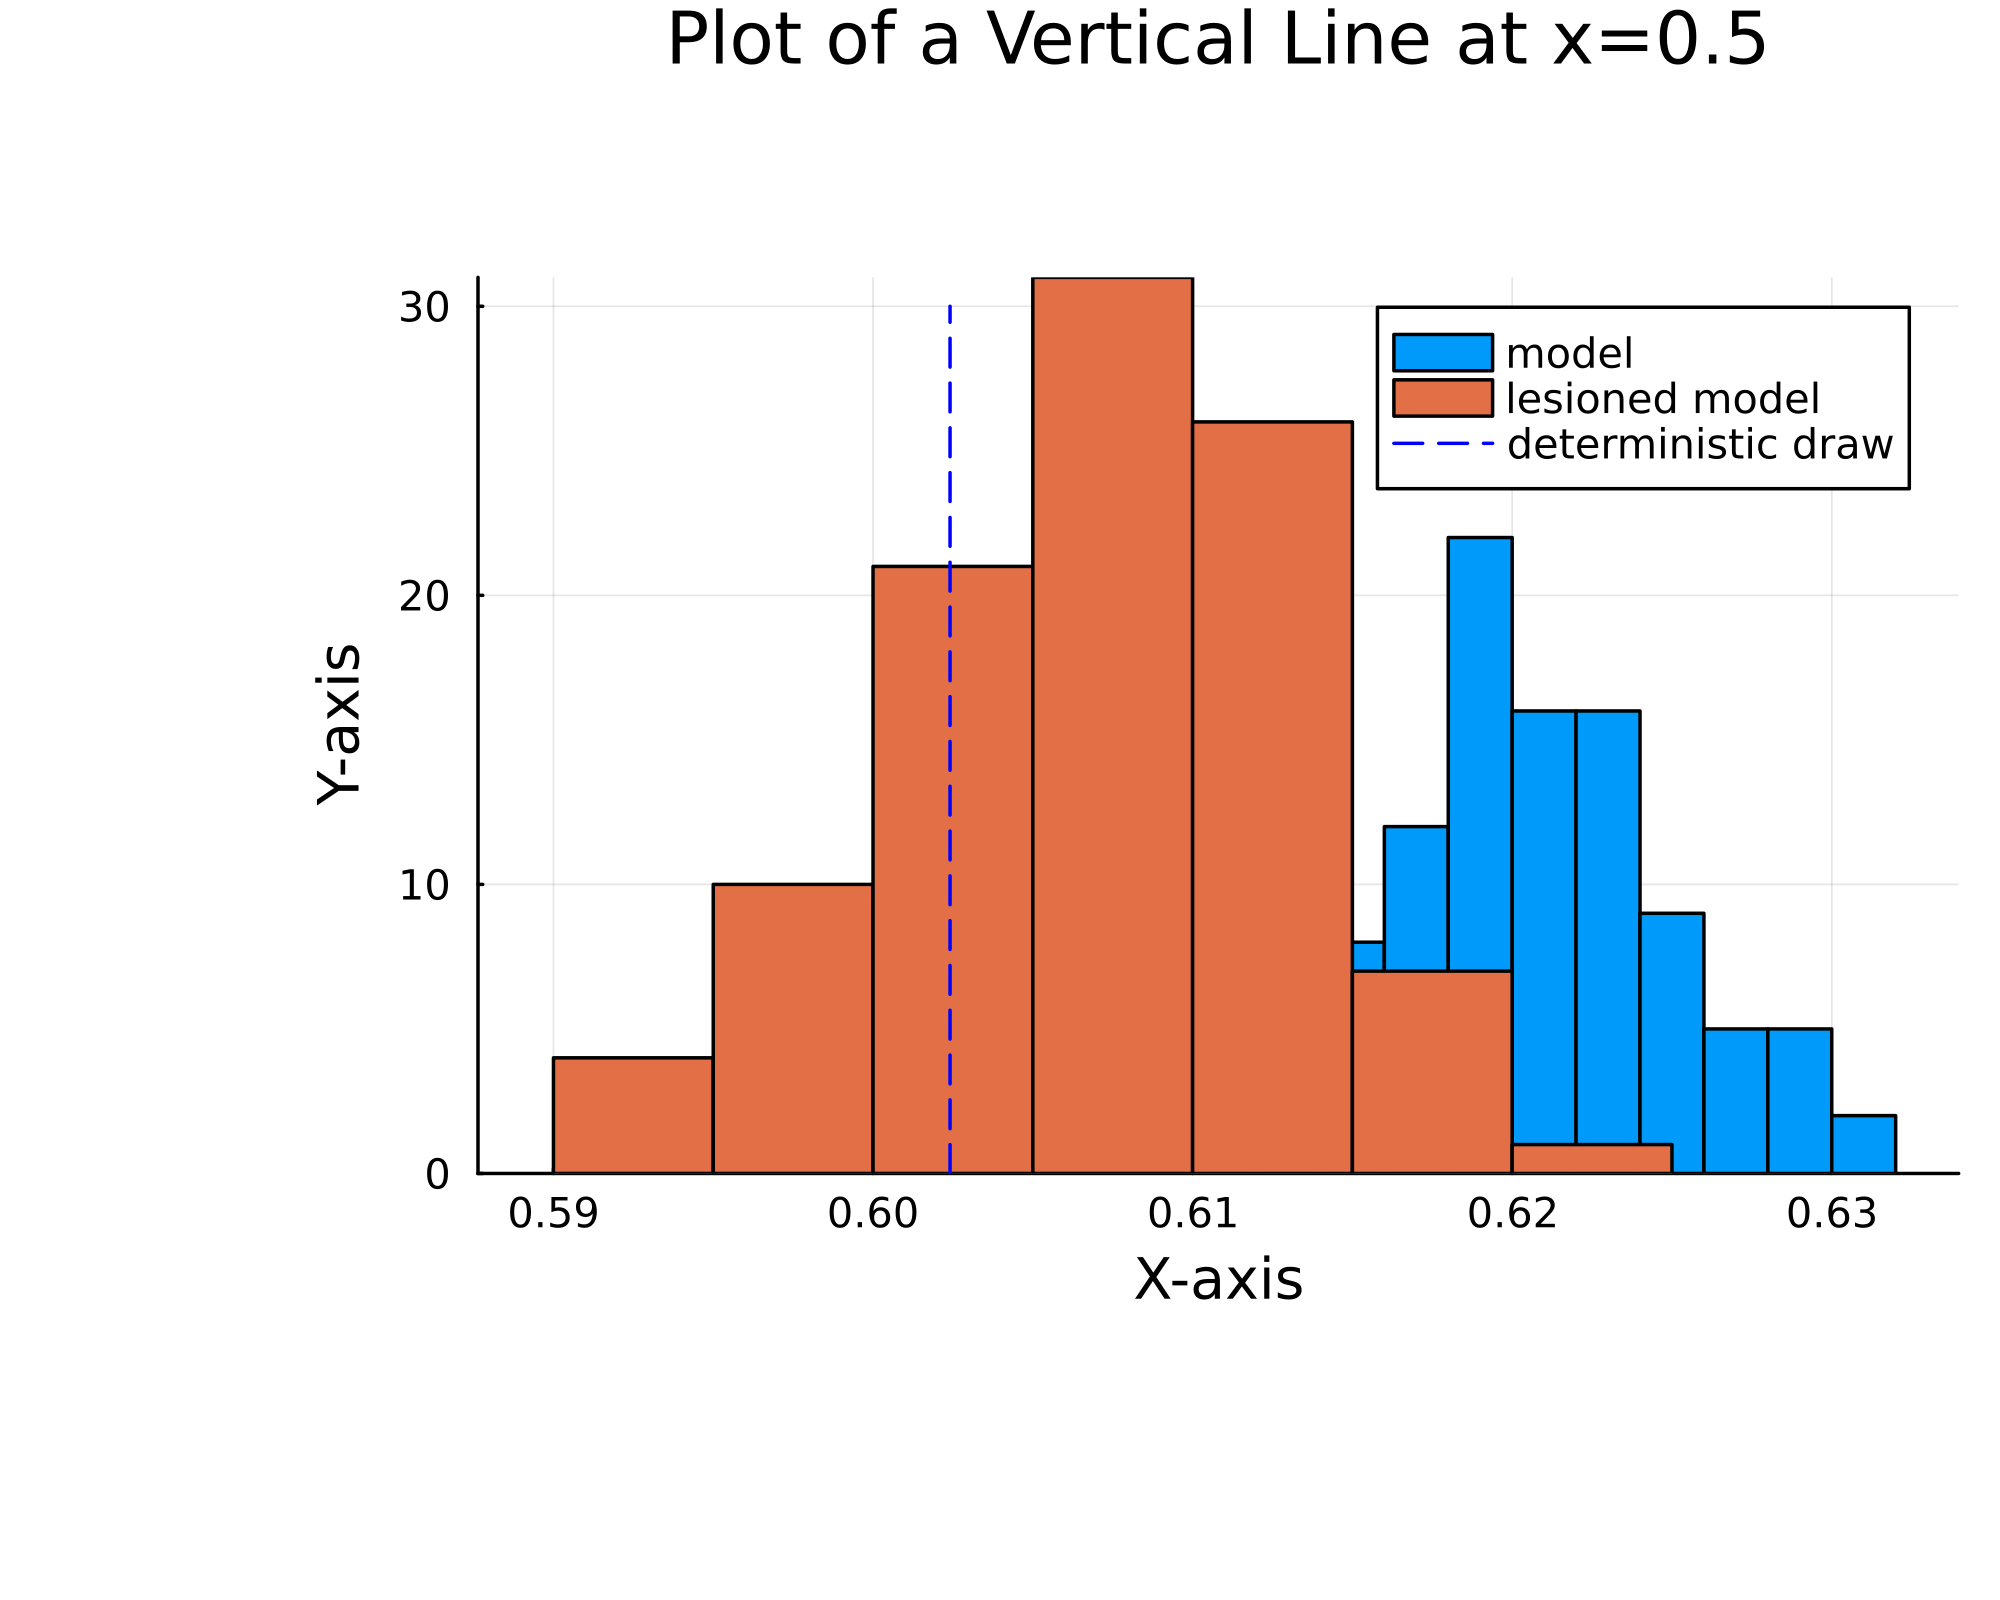

In [43]:
win_cat = Int.(reduce(vcat,win))
perc = []
for (j, sim_win) in enumerate(tot_sim_wins)
    sim = Int.(reduce(vcat,sim_win))
    correct =0
    count = 0
    for (i, game_win) in enumerate(win_cat)
        if sim[i] != 9999
            correct += (game_win == sim[i])
            count += 1
        else
            continue
        end
    end
    push!(perc,(correct / count))
end


    
perc1 = []
for (j, sim_win) in enumerate(tot_randsim_wins)
    sim = Int.(reduce(vcat,tot_sim_wins[1]))
    sim1 = Int.(reduce(vcat,sim_win))
    correct =0
    count = 0
    for (i, game_win) in enumerate(win_cat)
        if sim[i] != 9999
            correct += (game_win == sim1[i])
            count += 1
        else
            continue
        end
    end
    push!(perc1,(correct / count))
end



perc2 = []
for (j, sim_win) in enumerate(tot_drawn_wins)
    sim = Int.(reduce(vcat,tot_sim_wins[1]))
    sim2 = Int.(reduce(vcat,sim_win))
    correct =0
    count = 0
    for (i, game_win) in enumerate(win_cat)
        if sim[i] != 9999
            correct += (game_win == sim2[i])
            count += 1
        else
            continue
        end
    end
    push!(perc2,(correct / count))
end

#histogram!(perc2,thickness_scaling=3.5, size=(1000, 800), label="model")
#println(perc)
#println(perc2)
#histogram(perc,thickness_scaling=3.5, size=(1000, 800), label="model")
y = 0:30
histogram(perc,thickness_scaling=3.5, size=(2000, 1600), label="model")
histogram!(perc1,thickness_scaling=3.5, size=(2000, 1600), label="lesioned model")
plot!(repeat([perc2[1]], length(y)), y,size=(2000, 1600), label="deterministic draw", xlabel="X-axis", ylabel="Y-axis", title="Plot of a Vertical Line at x=0.5", linestyle=:dash, color=:blue) 
            


In [46]:
open("sim_selfelo_$n" * "iters.txt", "w") do file
    write(file, string(tot_sim_self_elo))
end
open("randsim_selfelo_$n" * "iters.txt", "w") do file
    write(file, string(tot_randsim_self_elo))
end
        
open("sim_otherelo_$n" * "iters.txt", "w") do file
    write(file, string(tot_sim_other_elo))
end
open("randsim_otherelo_$n" * "iters.txt", "w") do file
    write(file, string(tot_randsim_other_elo))
end
open("selfelo.txt", "w") do file
    write(file, string(self_elo))
end
open("otherelo.txt", "w") do file
    write(file, string(other_elo))
end
                        ;

147916